In [1]:
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from tqdm import tqdm
from obspy.geodetics import locations2degrees, degrees2kilometers

### Load the event data

In [2]:
import pandas as pd

# Load all the pick assignments 
mycatalog_picks = pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv')

# Drop duplicates and create a copy to avoid SettingWithCopyWarning
mycatalog = mycatalog_picks.drop_duplicates(subset=['idx']).copy()

# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc=True)

# Print mycatalog
mycatalog

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,10,-0.685211,BABR,P,1.465001e+09,2016-06-04 00:35:30.430365+00:00


In [7]:
mycatalog['datetime'].info

<bound method Series.info of 0   2016-06-04 00:35:30.430365+00:00
Name: datetime, dtype: datetime64[ns, UTC]>

In [17]:
mycatalog_picks

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,10,-0.685211,BABR,P,1.465001e+09
1,1,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,24,-0.839957,BABR,S,1.465001e+09
2,2,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,21,0.746129,DBO,S,1.465001e+09
3,3,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,4,-0.944046,FISH,P,1.465001e+09
4,4,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,18,-0.463162,FISH,S,1.465001e+09
5,5,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,1,0.922904,HYS14,P,1.465001e+09
6,6,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,3,0.654513,HYSB1,P,1.465001e+09
7,7,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,8,-0.366367,JEDS,P,1.465001e+09
8,8,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,22,0.080618,JEDS,S,1.465001e+09
9,9,0,2016-06-04 00:35:30.430365+00:00,-49.492017,-52.653525,45.703125,12,44.024477,-126.117313,45.703125,0,5,-0.095213,RADR,P,1.465001e+09


### Plot the waveforms

In [3]:
client = WaveformClient()
client2 = Client("IRIS")

In [4]:
# Obtain the station and network information 
all_picks_OR= pd.read_csv('/home/hbito/cascadia_obs_ensemble/data/datasets_OR/all_picks_OR.csv')
all_picks_OR = all_picks_OR.drop_duplicates(subset='station_code')
networks_stas=np.array(all_picks_OR[['station_network_code','station_code']])


In [ ]:
new_event_example_picks_WA_OR_idx_424 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_WA_OR_idx_424['idx']]
new_event_example_picks_WA_OR_idx_424

In [5]:
pick_sta=np.unique(mycatalog_picks['station'])
pick_sta

array(['BABR', 'DBO', 'FISH', 'HYS14', 'HYSB1', 'JEDS', 'RADR', 'WISH'],
      dtype=object)

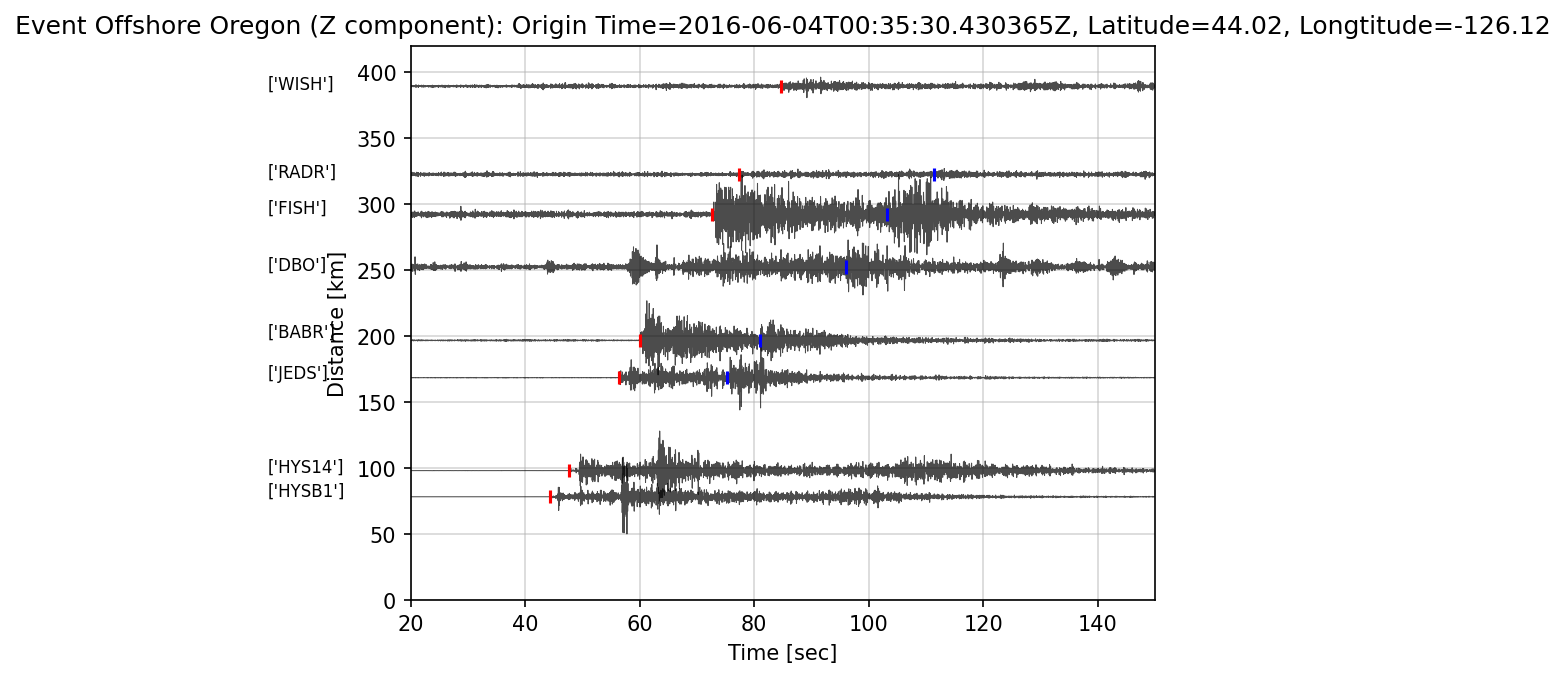

In [27]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
# event = new_events_deg.iloc[idx]
event=mycatalog
new_event_example_picks = mycatalog_picks
pick_sta = pick_sta

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event["datetime"].iloc[0])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="NV,OO,UW,UO",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        wave=trim_st[0].data
        wave=wave/np.nanmax(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),wave *30+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Event Offshore Oregon (Z component): Origin Time={otime}, Latitude={round(event['latitude'].iloc[0],2)}, Longtitude={round(event['longitude'].iloc[0],2)}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(0,420)
plt.xlim(20,150)

plt.grid(alpha=0.5)

plt.savefig("event_offshore_OR.pdf", format="pdf", bbox_inches="tight")
plt.show()

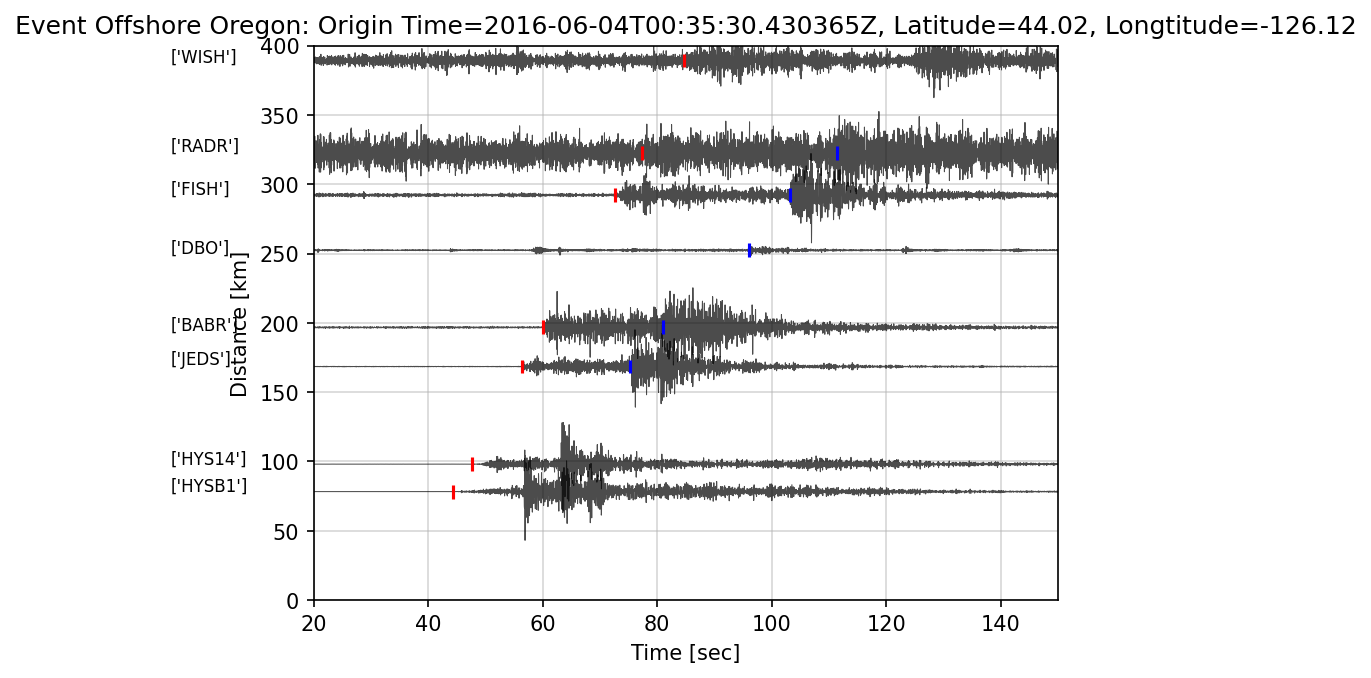

In [25]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
# event = new_events_deg.iloc[idx]
event=mycatalog
new_event_example_picks = mycatalog_picks
pick_sta = pick_sta

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event["datetime"].iloc[0])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="NV,OO,UW,UO",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HE", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        wave=trim_st[0].data
        wave=wave/np.nanmax(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),wave *30+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Event Offshore Oregon (E component): Origin Time={otime}, Latitude={round(event['latitude'].iloc[0],2)}, Longtitude={round(event['longitude'].iloc[0],2)}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(0,420)
plt.xlim(20,150)

plt.grid(alpha=0.5)

plt.savefig("event_offshore_OR.pdf", format="pdf", bbox_inches="tight")
plt.show()

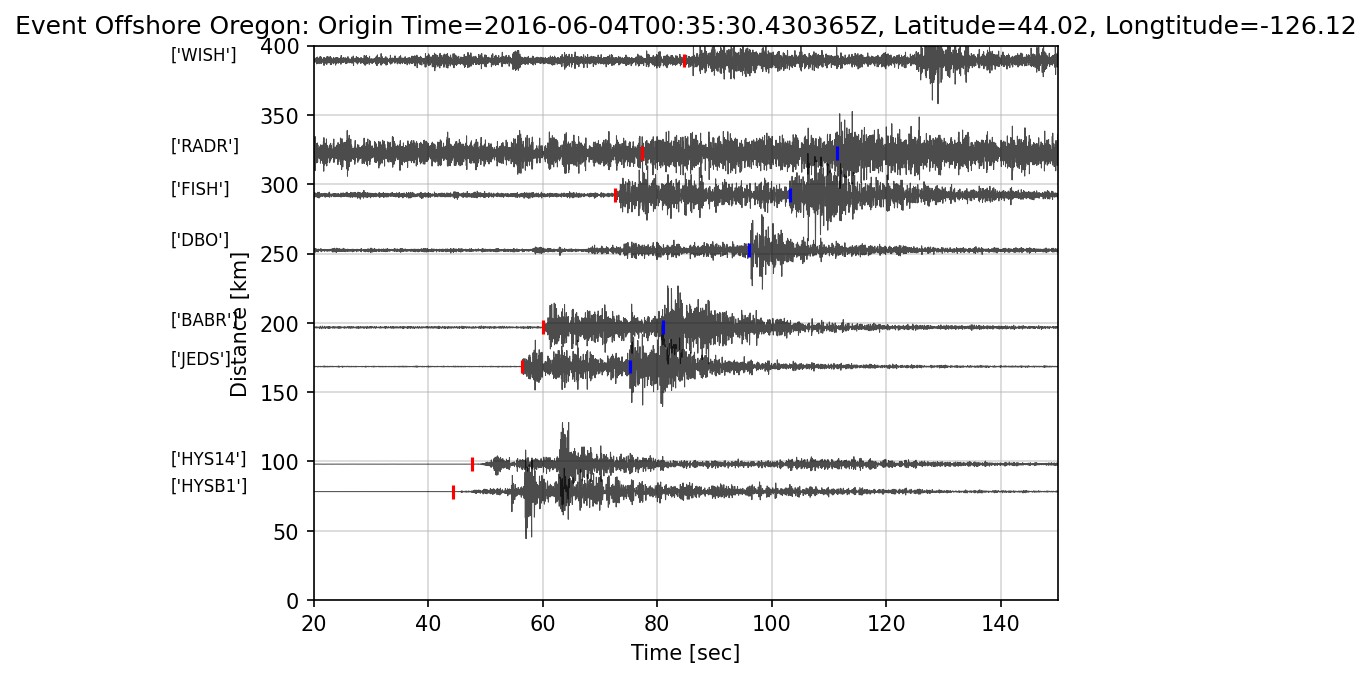

In [26]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
# event = new_events_deg.iloc[idx]
event=mycatalog
new_event_example_picks = mycatalog_picks
pick_sta = pick_sta

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event["datetime"].iloc[0])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="NV,OO,UW,UO",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HN", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        wave=trim_st[0].data
        wave=wave/np.nanmax(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),wave *30+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Event Offshore Oregon (N component): Origin Time={otime}, Latitude={round(event['latitude'].iloc[0],2)}, Longtitude={round(event['longitude'].iloc[0],2)}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(0,400)
plt.xlim(20,150)

plt.grid(alpha=0.5)

plt.savefig("event_offshore_OR.pdf", format="pdf", bbox_inches="tight")
plt.show()